<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Multivariate time series Rossmann

---


In [1]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#### Get the data

In [3]:
df = pd.read_csv('../../../../resource-datasets/rossmann_stores/rossmann.csv')
# Set the DateTime index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [4]:
# Filter to Store 1
store1_data = df[df.Store == 1]

# Filter to open days
data = store1_data[store1_data.Open == 1].sort_values(by='Date')

In [5]:
# obtain custom datetime index frequency taking into account business days Monday to Saturday
# serves for having index with defined frequency for later plotting
start = data.index.min()
end = data.index.max()
weekmask = 'Mon Tue Wed Thu Fri Sat'
new_index = pd.bdate_range(start=start, end=end, freq='C', weekmask=weekmask)
# check which days are too much
# turns out these are holidays in Germany (in the state of store 1)
merged = pd.merge(data[['Sales']], pd.DataFrame(list(range(len(
    new_index))), index=new_index), left_index=True, right_index=True, how='outer')
holidays = merged[merged.Sales.isna()].index
# now take business days and holidays into account
new_index = pd.bdate_range(
    start=start, end=end, freq='C', weekmask=weekmask, holidays=holidays)
data.index = new_index

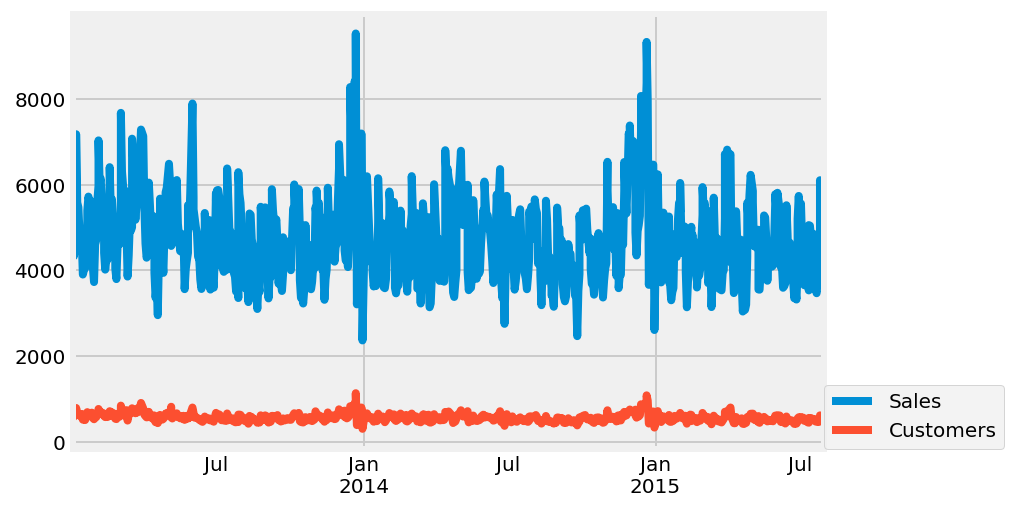

In [6]:
data = pd.get_dummies(data, columns=['DayOfWeek', 'StateHoliday'])
# Plot sales for Store 1 (all days) over time
data[['Sales', 'Customers']].plot()
plt.legend(loc=[1, 0])
plt.show()

#### Use differencing to make the time series stationary.

In [7]:
df_1 = data.diff()[1:]

In [8]:
df_1.head()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,StateHoliday_0,StateHoliday_0
2013-01-03,0.0,-1203.0,-90.0,0.0,0.0,0.0,0.0,0.0,255.0,1.0,0.0,0.0,0.0,0.0
2013-01-04,0.0,159.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,1.0,0.0,0.0,0.0
2013-01-05,0.0,511.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,255.0,1.0,0.0,0.0
2013-01-07,0.0,2179.0,150.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0
2013-01-08,0.0,-1596.0,-131.0,0.0,0.0,0.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
columns = ['Sales', 'Customers']

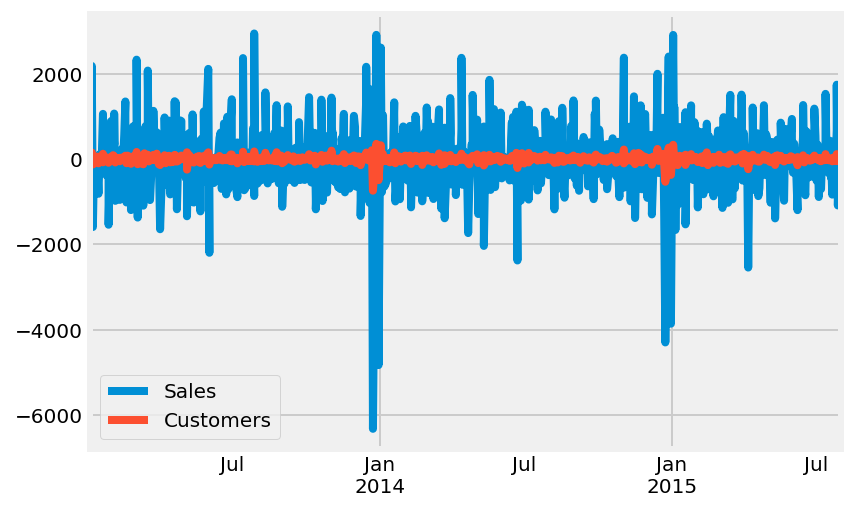

In [10]:
df_1[columns].plot()
plt.show()

#### Visualise the time series.

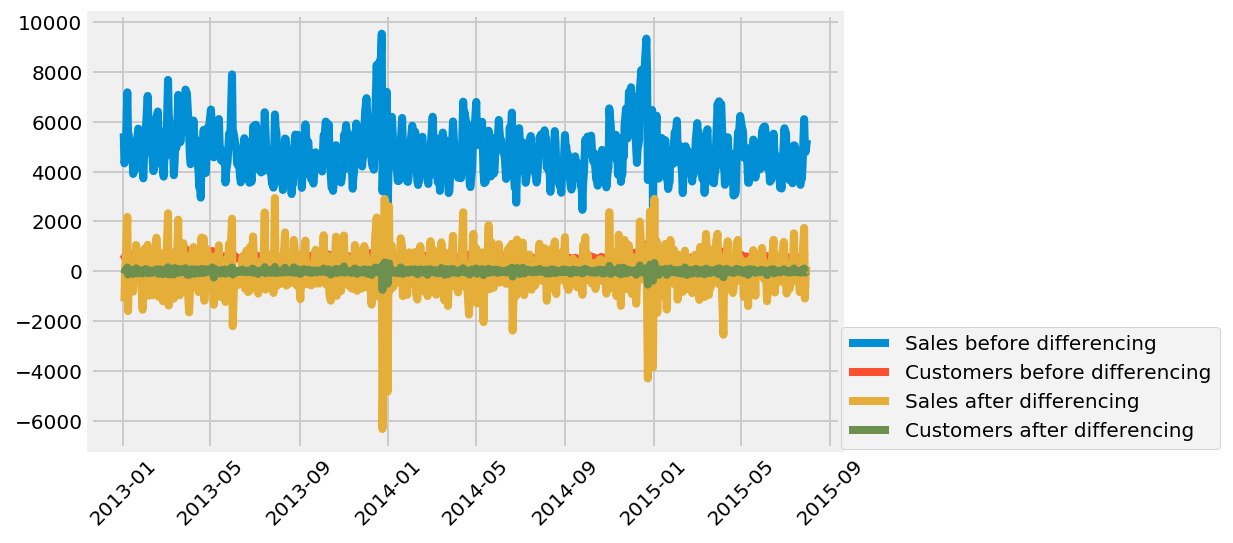

In [11]:
list_labels = [columns[i]+' before differencing' for i in range(len(columns))]
list_labels.extend(
    [columns[i]+' after differencing' for i in range(len(columns))])

plt.plot(data[columns], label='before differencing')
plt.plot(df_1[columns], label='after differencing')
plt.legend(list_labels, loc=[1, 0])
plt.xticks(rotation=45)
plt.show()
plt.show()

#### Look at the values of the cross correlation matrix at every lag for each pair of variables.

In [12]:
from itertools import combinations

In [13]:
[i for i in combinations((df[columns]), 2)]

[('Sales', 'Customers')]

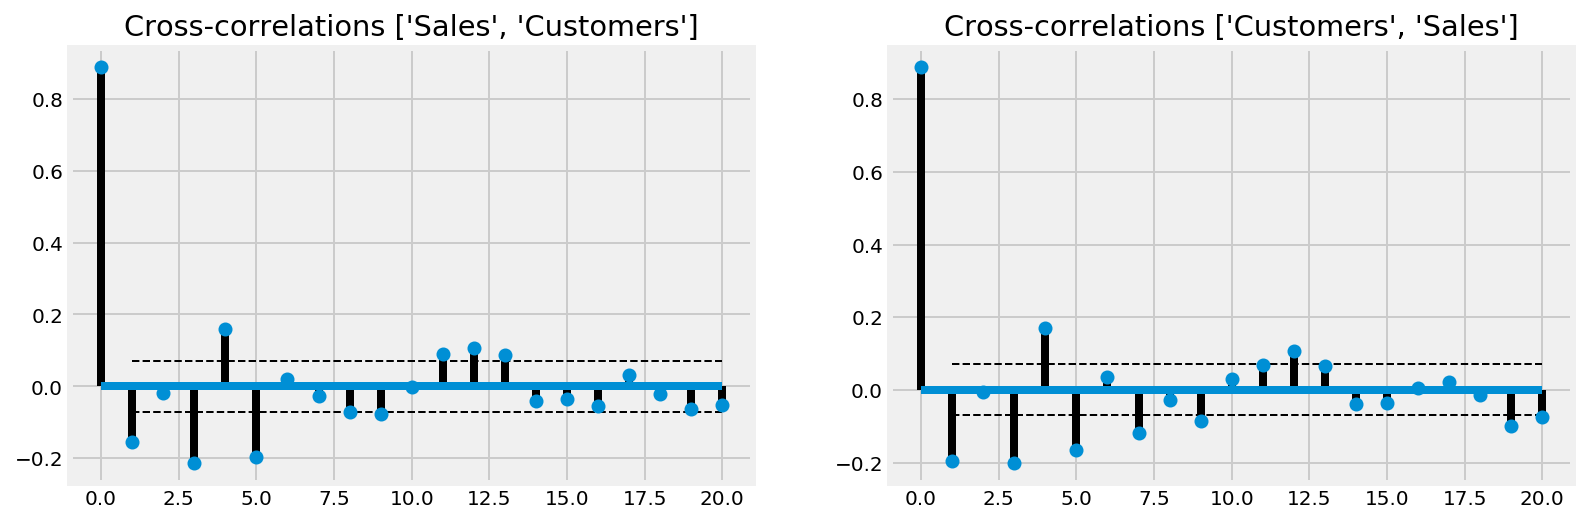

In [14]:
alpha = 0.05
se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(df_1))
ccf_01 = ccf(df_1[columns[0]], df_1[columns[1]])
ccf_10 = ccf(df_1[columns[1]], df_1[columns[0]])

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].stem(ccf_01[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[0].set_title('Cross-correlations {}'.format(columns))
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
ax[1].stem(ccf_10[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[1].set_title('Cross-correlations {}'.format(columns[::-1]))
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.show()

#### Fit different VARMA models. 

In [15]:
model = sm.tsa.VARMAX(df_1[columns], order=(1, 1), trend='nc')
results = model.fit(maxiter=5000, method='powell', disp=False)
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Sales', 'Customers']",No. Observations:,780
Model:,"VARMA(1,1)",Log Likelihood,-10087.598
Date:,"Mon, 19 Aug 2019",AIC,20197.196
Time:,23:56:35,BIC,20248.448
Sample:,01-03-2013,HQIC,20216.908
,- 07-31-2015,,
Covariance Type:,opg,,
Ljung-Box (Q):,"239.92, 95.19",Jarque-Bera (JB):,"1808.04, 358.25"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.19, 1.11",Skew:,"-0.74, -0.12"
Prob(H) (two-sided):,"0.16, 0.42",Kurtosis:,"10.31, 6.31"


#### Extract the AR and MA coefficient matrices.

In [16]:
print((results.coefficient_matrices_var))

[[[ 0.12820569 -2.54718356]
  [ 0.07719166 -0.3928301 ]]]


In [17]:
print((results.coefficient_matrices_vma))

[[[-0.0449488   0.38892737]
  [-0.02849157 -0.34087208]]]


#### Search for the best AR model according to AIC and BIC.

In [18]:
for i in range(1, 10):
    model = sm.tsa.VARMAX(df_1[columns], order=(i, 0))
    results = model.fit(maxiter=2000, disp=False)
    print((i, results.aic, results.bic))

(1, 20274.480228597153, 20316.413873874306)
(2, 20216.20360555332, 20276.774426509208)
(3, 20124.164207434034, 20203.372204068655)
(4, 20102.940731502673, 20200.785903816028)
(5, 20023.834307953166, 20140.31665594526)
(6, 19975.289802142535, 20110.40932581336)
(7, 19922.846185495873, 20076.602884845433)
(8, 19897.63070702797, 20070.024582056263)
(9, 19876.619349824046, 20067.650400531074)


In [19]:
for i in range(10, 16):
    model = sm.tsa.VARMAX(df_1[columns], order=(i, 0))
    results = model.fit(maxiter=2000, disp=False)
    print((i, results.aic, results.bic))

(10, 19850.013435349403, 20059.681661735165)
(11, 19827.997482143765, 20056.302884208264)
(12, 19834.138003495704, 20081.080581238937)
(13, 19840.56330156108, 20106.143054983047)
(14, 19846.183680997176, 20130.400610097877)
(15, 19846.907724175682, 20149.761828955117)


In [20]:
model = sm.tsa.VARMAX(df_1[columns], order=(11, 0))
results = model.fit(maxiter=1000, disp=False)

In [21]:
results.summary()

Dep. Variable:,"['Sales', 'Customers']",No. Observations:,780
Model:,VAR(11),Log Likelihood,-9864.999
,+ intercept,AIC,19827.997
Date:,"Mon, 19 Aug 2019",BIC,20056.303
Time:,23:58:39,HQIC,19915.807
Sample:,01-03-2013,,
,- 07-31-2015,,
Covariance Type:,opg,,
Ljung-Box (Q):,"62.25, 33.63",Jarque-Bera (JB):,"698.74, 176.16"
Prob(Q):,"0.01, 0.75",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.14, 1.15",Skew:,"-0.39, 0.03"


In [22]:
coeffs_ar = results.coefficient_matrices_var
print(coeffs_ar)

[[[-3.61235220e-01  4.76924070e-01]
  [ 3.14248108e-02 -7.21212801e-01]]

 [[-1.96646591e-01 -4.46454258e-01]
  [ 3.81839514e-02 -7.34423012e-01]]

 [[-3.83237605e-01  1.90569894e-01]
  [ 1.91113858e-02 -6.22930503e-01]]

 [[-1.91537209e-01  1.61821075e+00]
  [ 2.93622940e-02 -4.18960588e-01]]

 [[-5.34613811e-01  2.75034101e+00]
  [ 2.01034597e-03 -3.09981218e-01]]

 [[-7.50959658e-01  6.08099829e+00]
  [-2.12224538e-02  8.41746575e-02]]

 [[-8.13808431e-01  7.30132258e+00]
  [-3.46592399e-02  2.52076932e-01]]

 [[-4.71929107e-01  2.59017696e+00]
  [-8.67203855e-03 -1.06624502e-01]]

 [[-3.85197961e-01  2.19491670e+00]
  [-6.43855110e-03 -8.97287980e-02]]

 [[-2.80428506e-01  1.06489376e+00]
  [-2.50485052e-03 -1.18653418e-01]]

 [[-1.92937094e-01  1.11248758e+00]
  [-1.78785491e-03 -2.91667967e-02]]]


#### We can plot the residuals and obtain forecasts similar to the univariate case.

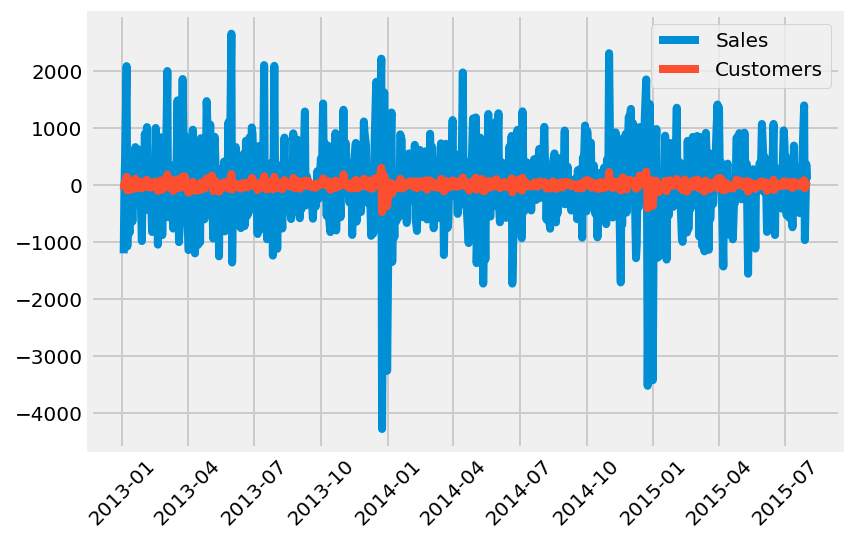

In [23]:
plt.plot(results.resid)
plt.legend([col for col in columns])
plt.xticks(rotation=45)
plt.show()

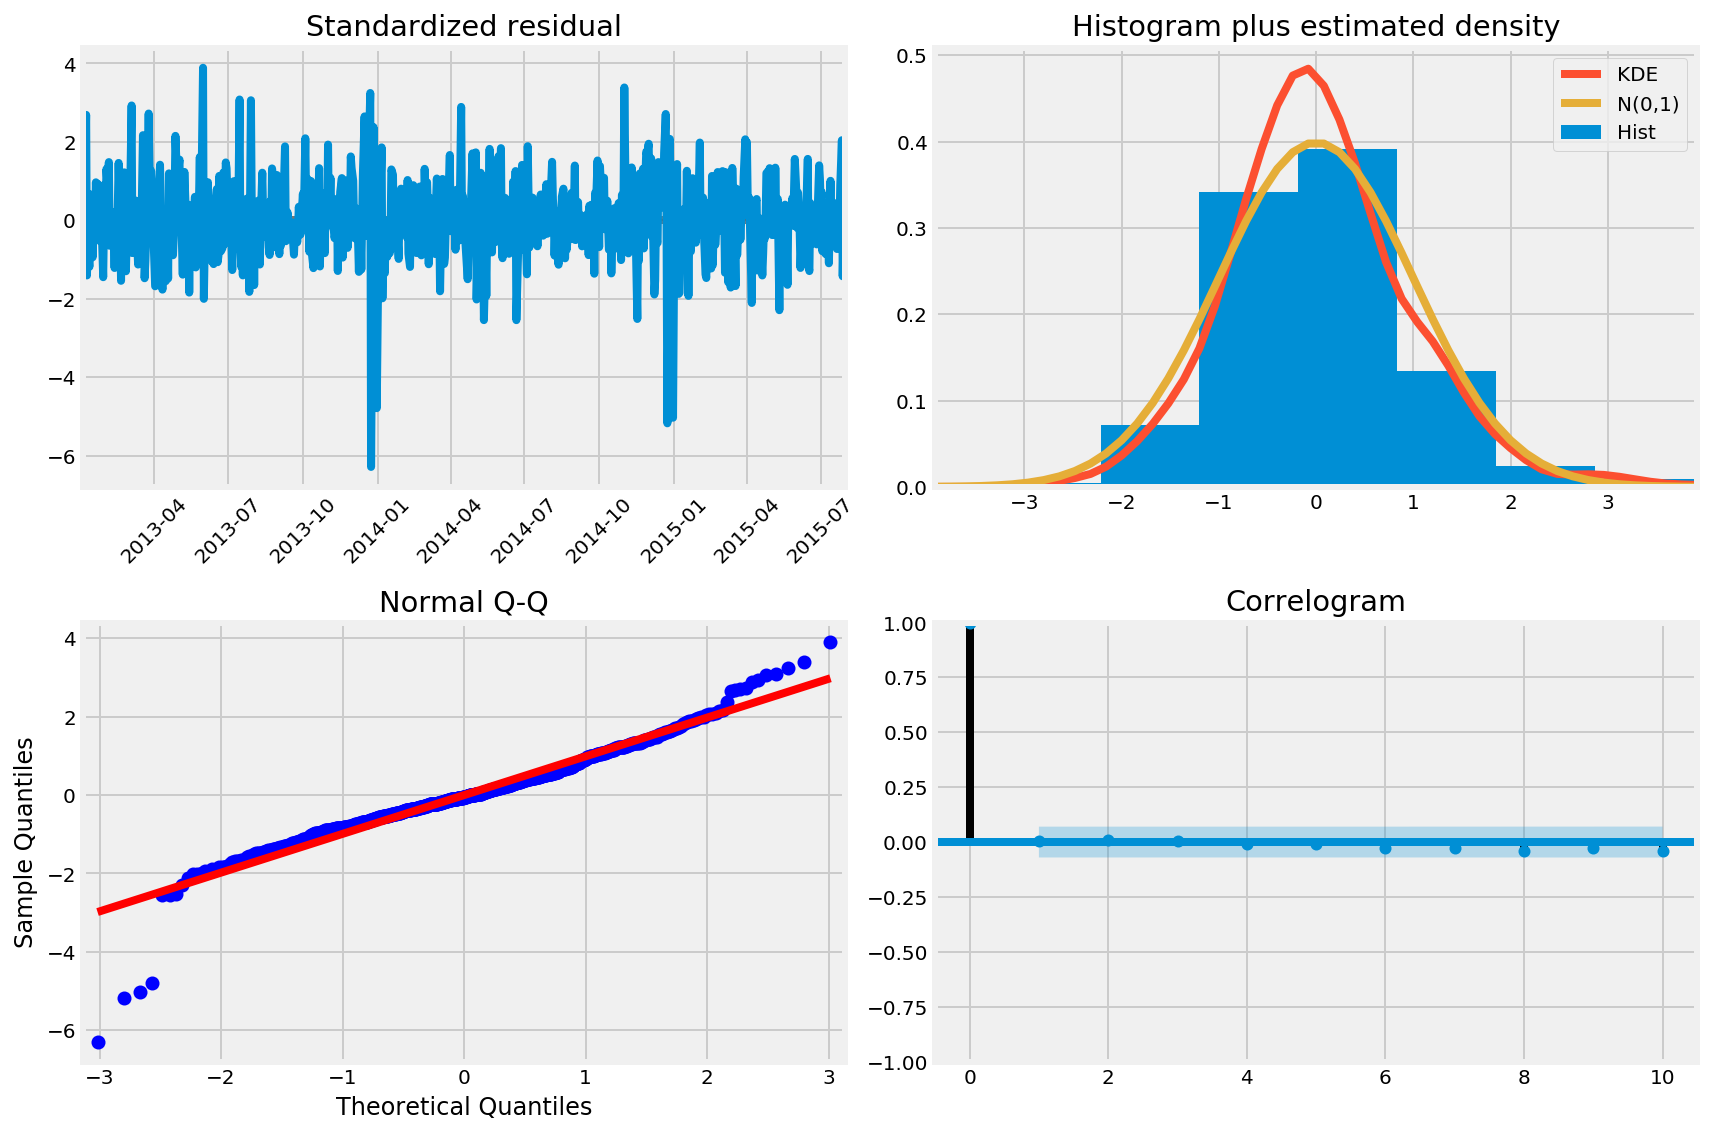

In [24]:
diag_plot = results.plot_diagnostics(0, figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

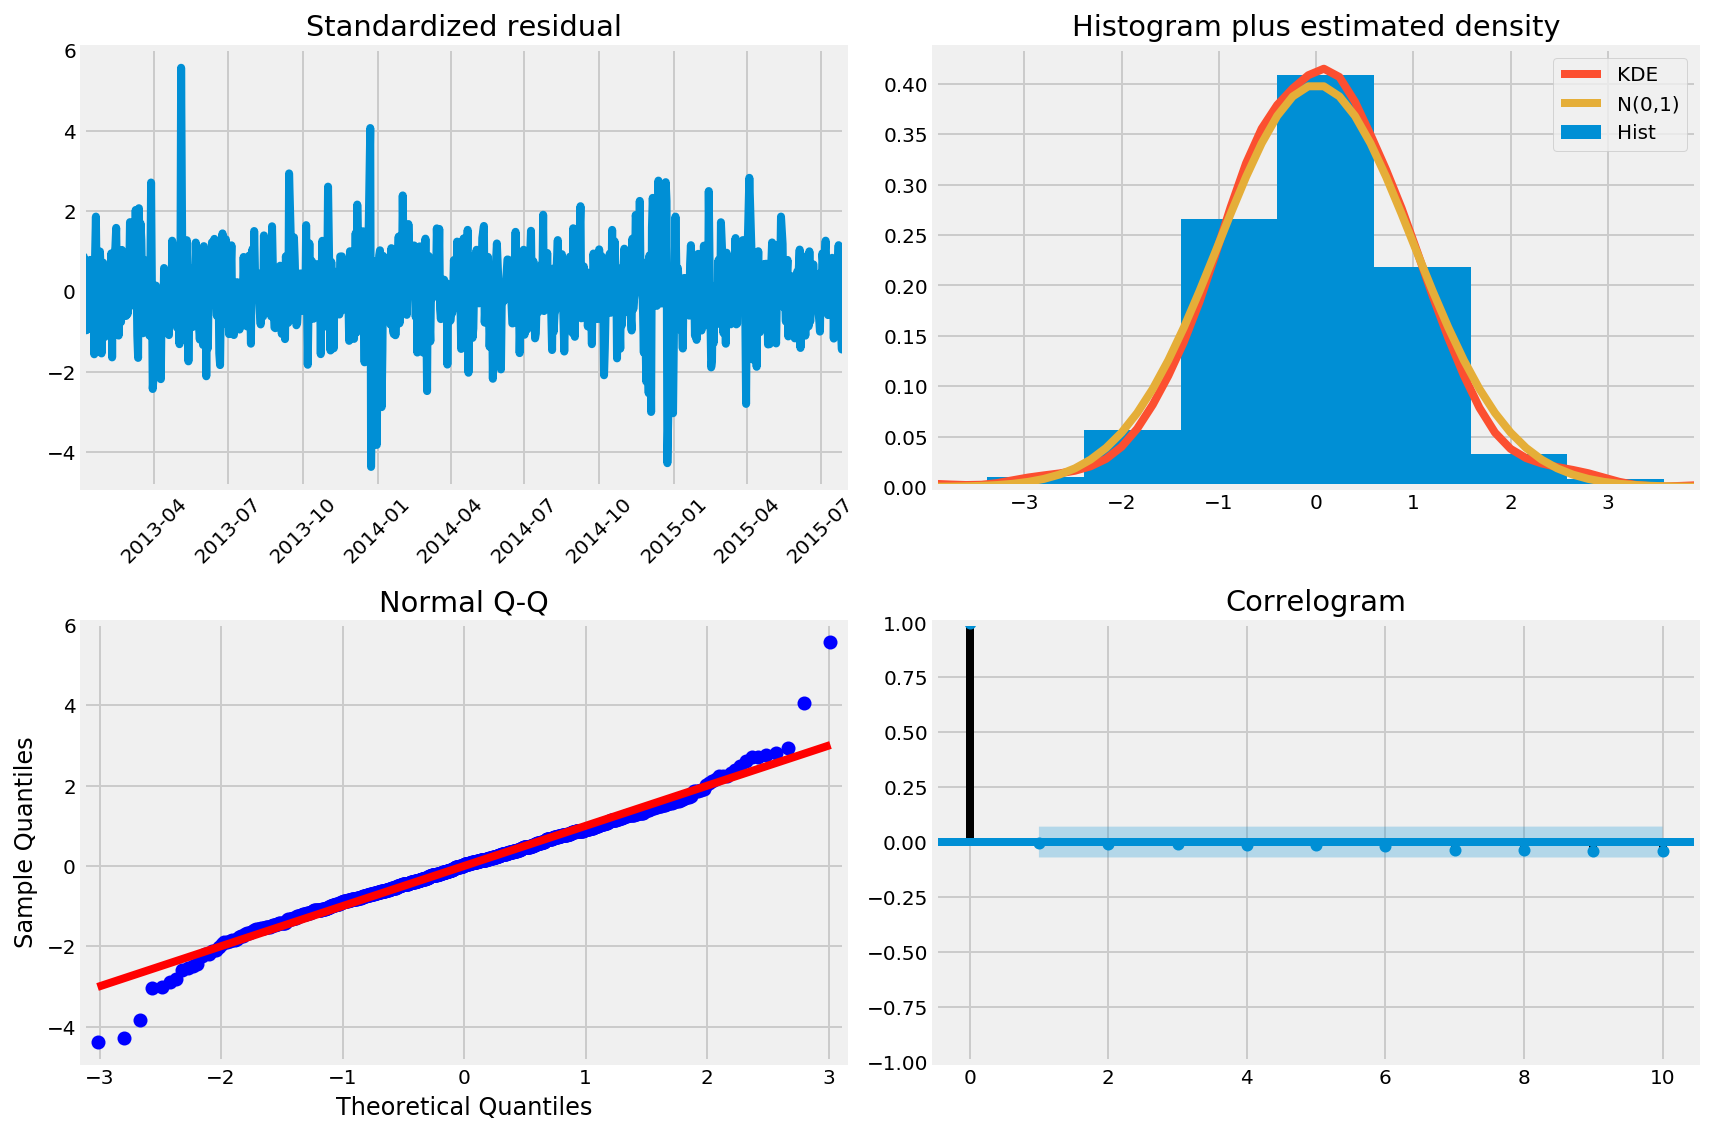

In [25]:
diag_plot = results.plot_diagnostics(1, figsize=(12, 8))
diag_plot.axes[0].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

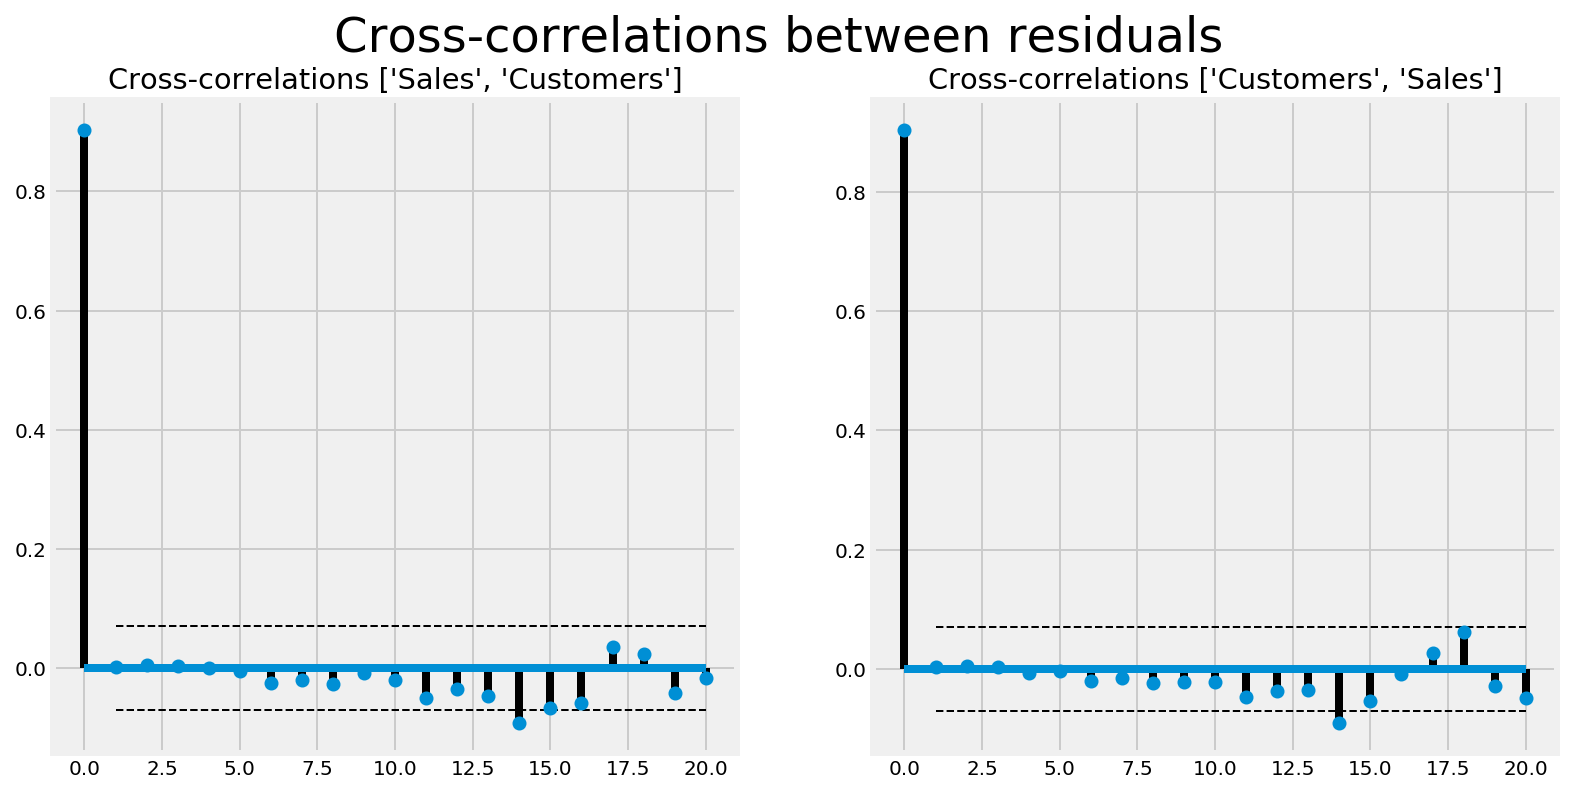

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].stem(ccf(results.resid.loc[:, columns[0]], results.resid.loc[:, columns[1]])[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[0].set_title('Cross-correlations {}'.format(columns))
ax[0].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
ax[1].stem(ccf(results.resid.loc[:, columns[1]], results.resid.loc[:, columns[0]])[:21], use_line_collection=True, linefmt='k', basefmt='')
ax[1].set_title('Cross-correlations {}'.format(columns[::-1]))
ax[1].hlines(np.array([-1, 1])*se, 1, 20, linestyles='--', lw=1)
plt.suptitle('Cross-correlations between residuals', fontsize=24)
plt.show()

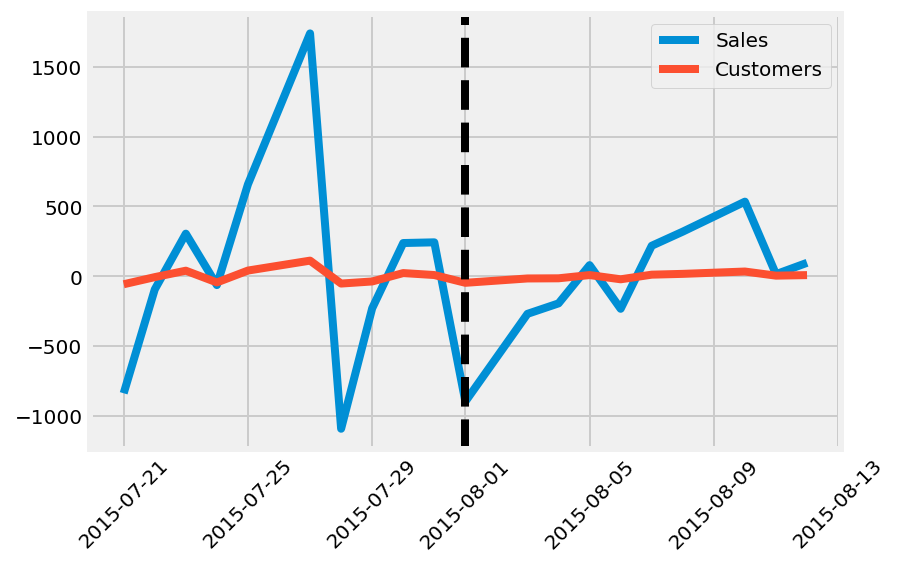

In [27]:
plt.plot(pd.concat((df_1[columns][-10:], results.forecast(10)), axis=0))
plt.axvline(results.forecast(10).index[0], color='k', ls='--')
plt.legend([col for col in columns])
plt.xticks(rotation=45)
plt.show()

In [28]:
# forecasting
start_p = 600
forecast_end = 100
data = df_1

preds = results.predict(start=1, end=len(data), dynamic=False)
preds.index = data.index
preds_dyn = results.predict(
    start=1+start_p, end=len(data)+forecast_end, dynamic=True)

In [29]:
preds.shape, preds_dyn.shape, data.shape

((780, 2), (280, 2), (780, 14))

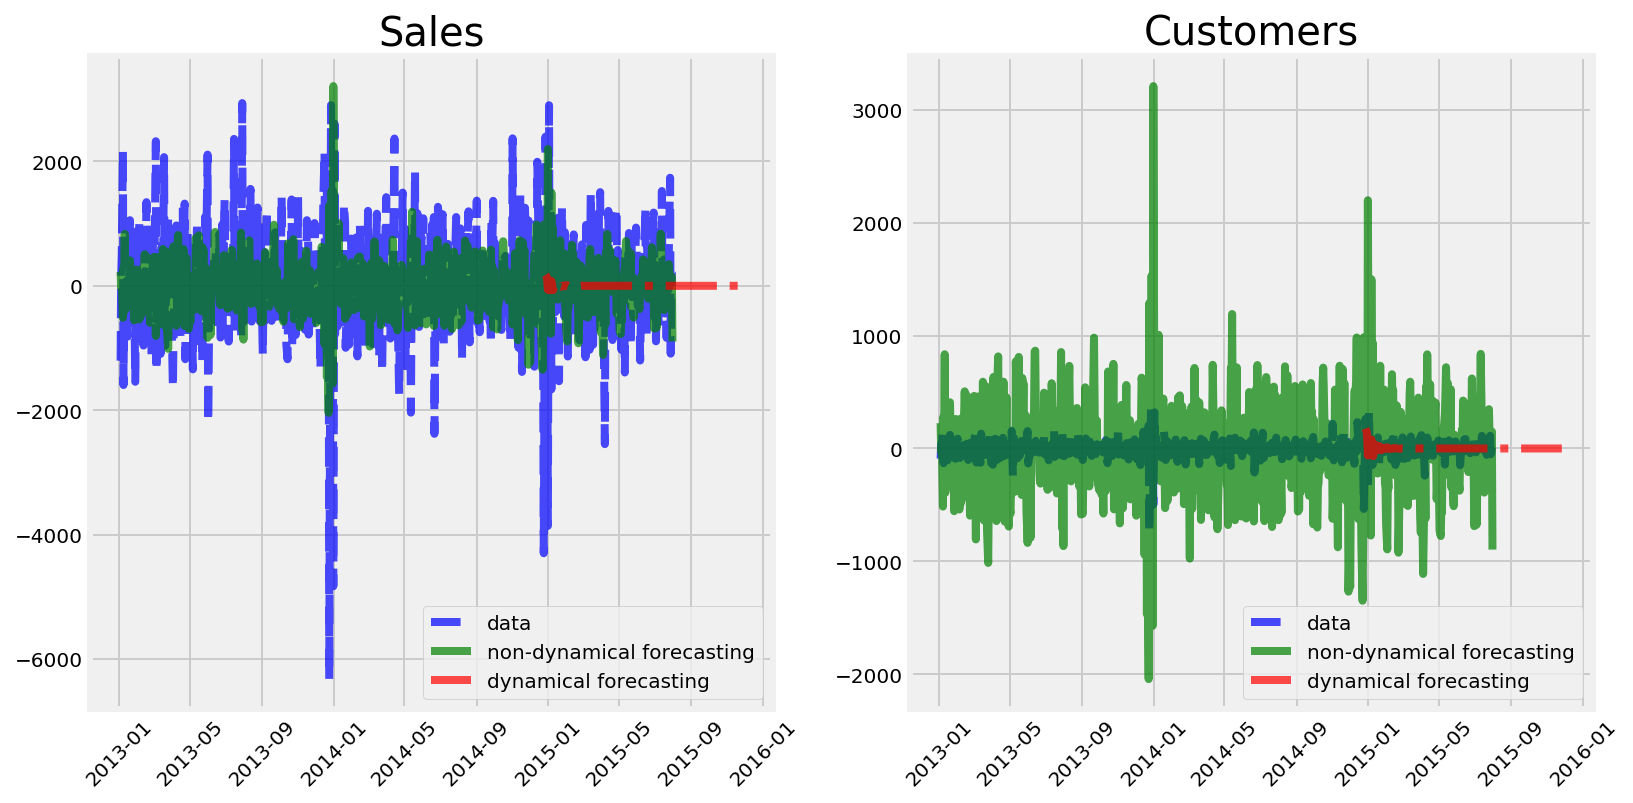

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].plot(data.Sales, 'b--', preds.Sales, 'g-',
           preds_dyn.Customers, 'r-.', alpha=0.7)
ax[0].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[0].set_title('Sales', fontsize=20)
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(data.Customers, 'b--', preds.Sales, 'g-',
           preds_dyn.Customers, 'r-.', alpha=0.7)
ax[1].legend(['data', 'non-dynamical forecasting',
              'dynamical forecasting'], loc='lower right')
ax[1].set_title('Customers', fontsize=20)
ax[1].tick_params(axis='x', rotation=45)

plt.show()

R2 values:

In [31]:
1-((np.square(results.resid)).mean(axis=0))/df_1[columns].var().values

Sales        0.300846
Customers    0.313534
dtype: float64

## Resources
---

- [Statsmodels documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html)
- [Statsmodels example](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_varmax.html)